In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import itertools as it

import sys
sys.path.append('..')

from src.sbm import fast_sbm_k_groups
from src.noisy_ba import noisy_er
from EM_ba import em_algo

## Generating our graphs

Here is an attempt to write the full likelihood of paper $X$, given some underlying adjacency matrix $A$ that is block structured. The likelihood is  

$$
P(\textbf{X}|\textbf{A},b,\theta) = \prod_{t=1}^{T} \Big\{
    \alpha \Big[ 
        \frac{1}{\sum_{j=1}^{n} g_{tj}} \sum_{i=1}^{n} g_{ti} \lambda_{s}^{c_{t} - 1} (1-\lambda_{s})^{d_{i} - c_{t} + 1}   
        \Big]
    (1-\alpha) \Big[
        \sum_{i=1}^{n} g_{ti} \lambda_{g}^{\sum_{r=1}^{K} b_{ir} z_{ti}} (1-\lambda_{g})^{\sum_{r=1}^{k} \mathcal{I}(\vec{b})_{r} b_{ir} z_{ti}}   
        \Big] 
    \Big\}
$$

where

 - $\sum_{r=1}^{k} b_{ir} z_{ti}$ are the people in group $r$ who are also on the paper $t$
 - $\sum_{r=1}^{k} \mathcal{I}(\vec{b})_{r} b_{ir} z_{ti}$ are the people in group $r$ who are not on the paper $t$. 
   - We use $\mathcal{I}(\vec{b})_{r}$ to denote block size for group $r$.

Recall that 

 - $z$: is of dim $T \times n$ and is the authors per paper
 - $b$: is of dim $n \times k$ and it the block matrix
 - $g$ is of dim $T \times n$ and is an incidence matrix of when node $i$ is 1 when on paper $t$
 - $c$ is of dim $T \times 1$ is the collaboration size for a paper $t$

## Generating Graphs (templates)

#### Fast SBM

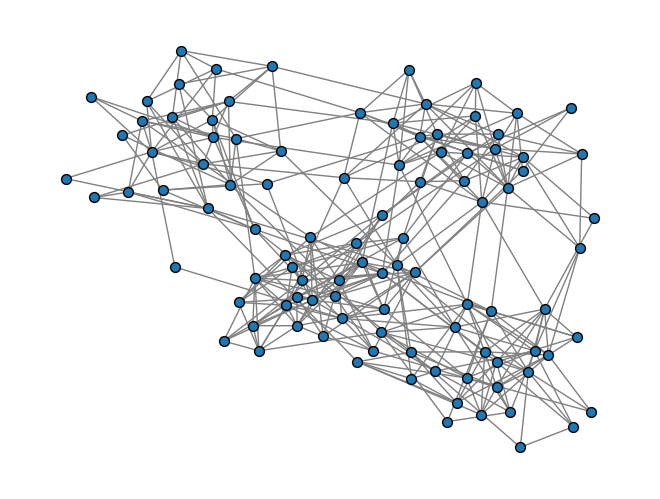

In [2]:
# Parameters for the SBM
c_in = 10  # Average number of within-community connections
c_out = 1  # Average number of between-community connections
K = 4
n = 100  # Total number of nodes

G = fast_sbm_k_groups(c_in, c_out, n, K)

nx.draw(G, node_size=50, edge_color='gray', edgecolors='black')
plt.show()

#### Noisy Barabasi Albert graph

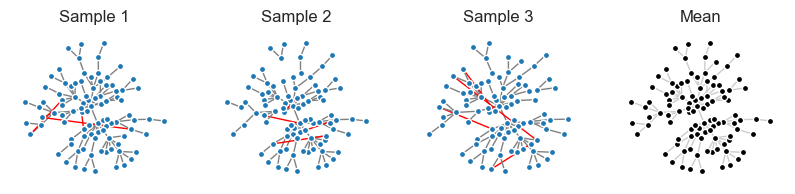

In [3]:
N = 3
alpha = 0.9
beta = 0.001

g, X = noisy_er()

pos = nx.kamada_kawai_layout(g)

plt.figure(figsize=(10, 2))

for t in range(N):
    plt.subplot(1, N + 1, t + 1)
    plt.title('Sample ' + str(t + 1))
    nx.draw(X[t], pos=pos, edgecolors='w', 
            edge_color=['gray' if e[2]['etype']=='tp' else 'r' for e in X[t].edges(data=True)],
            width=1, node_size=20)
    
plt.subplot(1, N + 1, N + 1)
plt.title('Mean')
nx.draw(g, pos=pos, node_color='k', edgecolors='w', edge_color='#CCCCCC', width=1, node_size=20)

## Running EM

## Noisy Barabasi albert graph

In [10]:
# summarize samples
E = np.zeros((n, n), dtype=int)
for i, j in it.combinations(range(n), 2):
    E[i, j] = np.sum([x.has_edge(i, j) for x in X])
    E[j, i] = E[i, j]

/var/folders/xb/yr7ybhzx6sg2hb1smfzmt9wm0000gp/T/ipykernel_36519/2372463914.py:20: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=2)


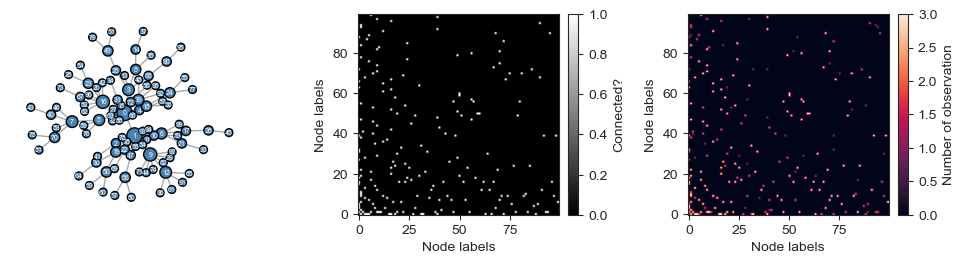

In [11]:
plt.figure(figsize=(10,3))
plt.subplot(131)
np.random.seed(8)
pos=nx.kamada_kawai_layout(g)
nx.draw(g, pos=pos, node_color='#4682B4', edgecolors='k', edge_color='#AAAAAA', node_size=[np.sqrt(g.degree[v]*1000) for v in g.nodes()])
nx.draw_networkx_labels(g, pos=pos, font_size=5, font_color='w')

plt.subplot(132)
im=plt.imshow(nx.linalg.adjacency_matrix(g).todense(), origin='lower', cmap=plt.cm.gray);
plt.colorbar(im, label='Connected?', fraction=0.046, pad=0.04)
plt.xlabel('Node labels')
plt.ylabel('Node labels')
plt.tight_layout(pad=2)

plt.subplot(133)
im = plt.imshow(E, origin='lower',   vmin=0, vmax=N);
plt.colorbar(im, label='Number of observation', fraction=0.046, pad=0.04)
plt.xlabel('Node labels')
plt.ylabel('Node labels')
plt.tight_layout(pad=2)

In [5]:
T = 20
theta_0 = (0.51,0.49, 0.5)

trajectory = em_algo(E, N, n, theta_0=theta_0, T=T)

In [6]:
trajectory_alpha = [theta_0[0]] + [t['alpha'] for t in trajectory]
trajectory_beta = [theta_0[1]] + [t['beta'] for t in trajectory]
trajectory_rho = [theta_0[2]] + [t['rho'] for t in trajectory]
trajectory_Q = [t['Q'] for t in trajectory]

In [7]:
print("True alpha = ", alpha, "| Estimated =", round(trajectory_alpha[-1], 4))
print("True beta = ", beta, "| Estimated =", round(trajectory_beta[-1], 4))
print("True rho = ", nx.density(g), "| Estimated =", round(trajectory_rho[-1], 4))

True alpha =  0.9 | Estimated = 0.1348
True beta =  0.001 | Estimated = 0.0
True rho =  0.02 | Estimated = 0.1359


/var/folders/xb/yr7ybhzx6sg2hb1smfzmt9wm0000gp/T/ipykernel_36519/917122140.py:17: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=2)


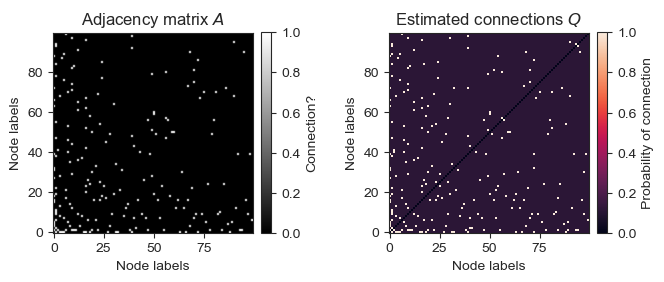

In [8]:
plt.figure(figsize=(7,5))

plt.subplot(121)
plt.title('Adjacency matrix $A$')
im=plt.imshow(nx.linalg.adjacency_matrix(g).todense(), origin='lower', cmap=plt.cm.gray);
plt.colorbar(im, label='Connection?', fraction=0.046, pad=0.04)
plt.xlabel('Node labels')
plt.ylabel('Node labels')
plt.tight_layout(pad=2)

plt.subplot(122)
plt.title('Estimated connections $Q$')
im = plt.imshow(trajectory_Q[-1], origin='lower',   vmin=0, vmax=1);
plt.colorbar(im, label='Probability of connection', fraction=0.046, pad=0.04)
plt.xlabel('Node labels')
plt.ylabel('Node labels')
plt.tight_layout(pad=2)